In [1]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [2]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/herwinvw/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [3]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Load images

In [7]:
from torch.utils.data import Dataset
from skimage import io, transform
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import transforms

In [8]:
import pandas as pd
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.images = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir+'/'+self.images.iloc[idx, 0]
        
        with Image.open(img_name) as image:
            if self.transform:
                image = self.transform(image)

        return (image, self.images.iloc[idx, 1])

In [9]:
image_folder = ImageDataset(csv_file='data/train.csv', root_dir='data/train_images', 
                           transform=transforms.Compose([transforms.Resize(200), 
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                                        ]))

## Define train and testsets

In [10]:
from torch.utils.data import random_split
N = len(image_folder)
train_dataset, test_dataset = random_split(image_folder, [int(N*0.8)+1, int(N*0.2)])

In [12]:
import torch
data_loader = torch.utils.data.DataLoader(train_dataset
    ,batch_size=25
    ,shuffle=True
    ,num_workers=2                                      
)

## Define the model

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
for param in resnet.parameters():
    param.requires_grad = False

In [19]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5)

In [20]:
import torch.optim as optim
optimizer = optim.Adam(resnet.parameters(), lr=0.05)
from evaluate import get_num_correct

In [23]:
import time
for epoch in range(10):
    total_loss = 0
    total_correct = 0
    N = 0
    start_time = time.time()
    for batch in data_loader:
        images, labels = batch 
        preds = resnet(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        N += len(preds)
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)888888
    print(
    "epoch:", epoch, 
    "accuracy:", round(100 * total_correct/N), '%',
    "total_correct", total_correct,
    "loss:", total_loss,
    "duration:", time.time()-start_time, 's'
    )

epoch: 0 accuracy: 63 % total_correct 10788 loss: 2741.192074537277 duration: 1234.2330725193024 s
epoch: 1 accuracy: 66 % total_correct 11361 loss: 2668.9496612995863 duration: 1246.107301235199 s
epoch: 2 accuracy: 68 % total_correct 11625 loss: 2418.3366504609585 duration: 1254.736091375351 s
epoch: 3 accuracy: 69 % total_correct 11783 loss: 2390.247774630785 duration: 1249.2198343276978 s
epoch: 4 accuracy: 69 % total_correct 11884 loss: 2487.213921971619 duration: 1254.5529272556305 s
epoch: 5 accuracy: 71 % total_correct 12112 loss: 2215.2726017832756 duration: 1263.0980880260468 s
epoch: 6 accuracy: 71 % total_correct 12072 loss: 2414.6377835571766 duration: 1252.8179144859314 s
epoch: 7 accuracy: 71 % total_correct 12079 loss: 2729.774435577914 duration: 1257.0953333377838 s
epoch: 8 accuracy: 71 % total_correct 12135 loss: 2546.921525388956 duration: 1251.1913137435913 s
epoch: 9 accuracy: 72 % total_correct 12268 loss: 2407.743045181036 duration: 1260.3471419811249 s


Accuracy: 0.7579740623904662


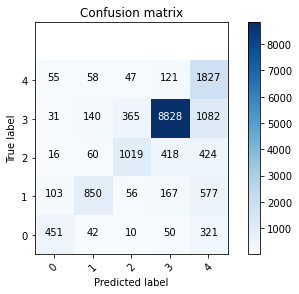

In [25]:
from evaluate import analyze_accuracy
analyze_accuracy(resnet, train_dataset, range(0,5))

Accuracy: 0.709277868660902


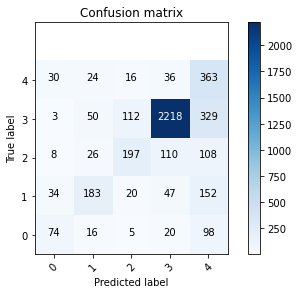

In [27]:
analyze_accuracy(resnet, test_dataset, range(0,5))